## Read data and show how many profile need to be predicted

In [1]:
# -*- coding: utf-8 -*-

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pickle
from collections import Counter

# load the graph
G = nx.read_gexf("mediumLinkedin.gexf")

college = {}
location = {}
employer = {}
# The dictionaries are loaded as dictionaries from the disk (see pickle in Python doc)
with open('mediumCollege_60percent_of_empty_profile.pickle', 'rb') as handle:
    college = pickle.load(handle)
with open('mediumLocation_60percent_of_empty_profile.pickle', 'rb') as handle:
    location = pickle.load(handle)
with open('mediumEmployer_60percent_of_empty_profile.pickle', 'rb') as handle:
    employer = pickle.load(handle)
# here are the empty nodes for whom your challenge is to find the profiles
empty_nodes = []
with open('mediumRemovedNodes_60percent_of_empty_profile.pickle', 'rb') as handle:
    empty_nodes = pickle.load(handle)

i = 0
for n in G:
    if len(list(G[n])) == 0:
        i += 1
print("Nb of users in our graph: %d" % len(G))
print("Nb of users with one or more attribute college: %d" % len(college))
print("Nb of users with one or more attribute location: %d" % len(location))
print("Nb of users with one or more attribute employer: %d" % len(employer))
print("Your mission, find attributes to %d users with empty profile" % len(empty_nodes))
print('isolated nodes number = ' + str(i))


Nb of users in our graph: 811
Nb of users with one or more attribute college: 230
Nb of users with one or more attribute location: 336
Nb of users with one or more attribute employer: 297
Your mission, find attributes to 475 users with empty profile
isolated nodes number = 0


## Make a function to draw a given graph with different nodes' colors

In [2]:
def drawGraph(g,color = True):
    print('drawing the Graph, be patient please ^-^')
    plt.figure(num=None, figsize=(30, 30), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(g, iterations=100)
    if color == True:
        node_colors = [g.node[v]['color'] for v in g]
        nx.draw_networkx(g,node_color = node_colors)
    elif color == False:
        nx.draw_networkx(g)
    plt.show()

## Functions to evaluate a given prediction with using the precision

In [3]:
# Mesure the accuracy function
def evaluation_accuracy(groundtruth, pred):
    true_positive_prediction = 0
    for p_key, p_value in pred.items():
        if p_key in groundtruth:
            # if prediction is no attribute values, e.g. [] and so is the groundtruth
            # May happen
            if not p_value and not groundtruth[p_key]:
                true_positive_prediction += 1
            # counts the number of good prediction for node p_key
            # here len(p_value)=1 but we could have tried to predict more values
            true_positive_prediction += len([c for c in p_value if c in groundtruth[p_key]])
            # no else, should not happen: train and test datasets are consistent
    return true_positive_prediction*100/sum(len(v) for v in pred.values())

# Test function which use The evaluation_accuracy function
def testLocation(location_prediction):
    groundtruth = {}
    with open('mediumLocation.pickle', 'rb') as handle:
        groundtruth_location = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_location, location_prediction)
    print('print the groudtruth rate for location_prediction')
    print("%f%% of the predictions are true" % result)
    return result
# test college
def testCollege(college_prediction):
    groundtruth = {}
    with open('mediumcollege.pickle', 'rb') as handle:
        groundtruth_college = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_college, college_prediction)
    print('print the groudtruth rate for college_prediction')
    print("%f%% of the predictions are true" % result)
    return result
# test employer
def testEmployer(employer_prediction):
    groundtruth = {}
    with open('mediumEmployer.pickle', 'rb') as handle:
        groundtruth_employer = pickle.load(handle)
    result = evaluation_accuracy(groundtruth_employer, employer_prediction)
    print('print the groudtruth rate for EmployerPrediction')
    print("%f%% of the predictions are true" % result)
    return result

# First Part
## Make prediction for the missing profile

## Function of prediction 
#### We suppose that each node will have same infomation with its' neighbors 

In [4]:
# Prediction by the most frequent attribut
def naive_method(attr,graph, empty):
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for nbr in graph.neighbors(n):
            if nbr in attr:
                for val in attr[nbr]:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            cpt=Counter(nbrs_attr_values)
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values

In [5]:
# Results for the naive method
l = naive_method(location,G,empty_nodes)
proba = testLocation(l)
proba = testCollege(naive_method(college,G,empty_nodes))
proba = testEmployer(naive_method(employer,G,empty_nodes))

print the groudtruth rate for location_prediction
32.352941% of the predictions are true
print the groudtruth rate for college_prediction
28.404669% of the predictions are true
print the groudtruth rate for EmployerPrediction
19.696970% of the predictions are true


## Function of prediction 
#### We suppose that each node in the graph will have same infomation with it's neighbor having a biggest degree

In [6]:
### Prediction by biggest degree neighbor 1
def prediction_by_ngb_degree(dict1,g=G, test=empty_nodes):
    prediction_dict = {}
    for n in test:
        ngbs = g[n]
        degreeMax = 0
        for ngb in ngbs:
            if g.degree(ngb) > degreeMax:
                degreeMax = g.degree(ngb)
                aime = ngb
        if ngb in dict1.keys():
            prediction_dict[n] = dict1[ngb]
    return prediction_dict

In [7]:
# test begin bigges DEGREE
proba = testLocation(prediction_by_ngb_degree(location))
proba = testCollege(prediction_by_ngb_degree(college))
proba = testEmployer(prediction_by_ngb_degree(employer))

print the groudtruth rate for location_prediction
24.113475% of the predictions are true
print the groudtruth rate for college_prediction
13.227513% of the predictions are true
print the groudtruth rate for EmployerPrediction
8.352144% of the predictions are true


## Function of prediction 
#### In this function we divide the given graph into 2 parts , nodes in a cluster or not.
#### and we suppose that nodes who are in the same cluster have same attributes and who are not will be implemented to a naive_method

In [8]:
from collections import ChainMap
# Prediction By the biggest cluster 
def prediction_by_cluster(attr,cluster_coef = 0.5,test=empty_nodes,g=G):
    #clustering analyse
    partial_clustering = nx.clustering(g)
#     print(partial_clustering)
    clusteringGroups = {}
    for pc_key in partial_clustering:
        pc_val = partial_clustering[pc_key]
        if pc_val >= cluster_coef:
            clusteringGroups[pc_key] = pc_val
    
    new_empty = []
    new_empty2 = []
    for n in test:
        for m in g[n]:
            if m in clusteringGroups and n not in new_empty:
                new_empty.append(n)
    for n in test:
        if n not in new_empty:
            new_empty2.append(n)
    
    dict1 = naive_method(attr,g,new_empty)
    at = ChainMap(dict1,attr)
    dict2 = prediction_by_ngb_degree(attr,g,new_empty2)
    dict3 = ChainMap(dict1,dict2)
    
    return dict3

In [9]:
# Result for the clustering prediction
proba = testLocation(prediction_by_cluster(location,0.5))
proba = testCollege(prediction_by_cluster(college,0.5))
proba  = testEmployer(prediction_by_cluster(employer,0.5))

print the groudtruth rate for location_prediction
32.800000% of the predictions are true
print the groudtruth rate for college_prediction
23.469388% of the predictions are true
print the groudtruth rate for EmployerPrediction
14.014252% of the predictions are true


## Function of prediction 
#### Find K_clique communities in the given graph 
#### and in each community we suppose that each node in the same community share same attribute.



In [10]:
def find_community(graph,k):
    return list(nx.algorithms.community.k_clique_communities(graph,k))

def prediction_by_community(attr,empty_nodes=empty_nodes,g=G):
    
    G1 = g
    rst_com = find_community(G1,5)
    rst_com = sorted(rst_com ,key = lambda t :len(t), reverse = True )
    color = ['blue','y','g','pink','black']
    for i in G1:
        G1.node[i]['color'] = 'r'
    for i in range(5):
        for user in rst_com[i]:
            G1.node[user]['color'] = color[i%len(color)]   
    
    predictions = {}
    for com in rst_com:
        empty_in_com = []
        prediction = {}
        nbrs_attr_values=[]
        for node in com:
            if node in empty_nodes:
                predictions[node]=[]
                prediction[node]=[]
                empty_in_com.append(node)
            if node in attr:
                for val in attr[node]:
                    nbrs_attr_values.append(val)       
        if nbrs_attr_values: # non empty list
            cpt=Counter(nbrs_attr_values)
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            for node in empty_in_com:
                prediction[node].append(a)
        for i,j in prediction.items():
            for k in j:
                predictions[i].append(k)
                
    emp = [v for v in predictions]
    pre2 = naive_method(attr,g,empty_nodes)
    attr_st = {}
    for i in attr:
        for j in attr[i]:
            if j not in attr_st:
                attr_st[j] = [i]
            else:
                attr_st[j].append(i)
    
    temp = sorted(attr_st.items(),key = lambda t:len(t[1]),reverse = True)
    attr_st = {temp[v][0]:v for v in range(len(temp))}

    for i in predictions:
        if pre2[i] != predictions[i] and pre2[i]!=[] and predictions[i]!=[] and attr_st[pre2[i][0]] < attr_st[predictions[i][0]]:
            predictions[i] = pre2[i]
        
    return predictions

In [11]:
testLocation(prediction_by_community(location))
testCollege(prediction_by_community(college))
a = testEmployer(prediction_by_community(employer))

print the groudtruth rate for location_prediction
51.351351% of the predictions are true
print the groudtruth rate for college_prediction
36.764706% of the predictions are true
print the groudtruth rate for EmployerPrediction
29.729730% of the predictions are true


## Function of prediction 
### This function is the best prediction function that we found
In this function we divide the given graph as 3 parts by using their degrees.

#### The high degree class 
 whose degree is larger than 10
#### The mid degree class 
whose degree is larger than 4 and smaller than 10
#### The low degree class
whose degree is smaller than 4

In [12]:
from collections import ChainMap

def prediction_degree_class(attr = location,G1 = G,empty_nodes = empty_nodes):
    # (i,j) for the degree i ,there are j people having this degree
    degrees = dict(G1.degree())
    node_high_dgr = []
    node_mid_dgr = []
    node_low_dgr = []
    for i in G1:
        if degrees[i] > 10:
            node_high_dgr.append(i)
        elif degrees[i] >= 4 :
            node_mid_dgr.append(i)
        else: 
            node_low_dgr.append(i)
    cpt = Counter(degrees.values())
    cpt = sorted(cpt.items(),key = lambda t: t[0],reverse = False)

    
    emp = []
    for i in node_high_dgr:
        if i in empty_nodes:
            emp.append(i)
    pre_naiv = naive_method(attr,G1,emp)
    # find_wrong_prediction(pre_naiv,pre2)

    loc_1 = ChainMap(attr,pre_naiv)
    emp = []
    for i in node_mid_dgr:
        if i in empty_nodes:
            emp.append(i)
    pre_naiv1 = naive_method(loc_1,G1,emp)

    loc_2 = ChainMap(loc_1,pre_naiv1)
    emp = []
    for i in node_low_dgr:
        if i in empty_nodes:
            emp.append(i)
    pre_naiv2 = naive_method(loc_2,G1,emp)
    return pre_naiv,pre_naiv1,pre_naiv2

In [13]:
pre = prediction_degree_class(location)
testLocation(ChainMap(pre[0]))
pre = prediction_degree_class(college)
testCollege(ChainMap(pre[0]))
pre = prediction_degree_class(employer)
a = testEmployer(ChainMap(pre[0]))

print the groudtruth rate for location_prediction
56.666667% of the predictions are true
print the groudtruth rate for college_prediction
40.000000% of the predictions are true
print the groudtruth rate for EmployerPrediction
43.333333% of the predictions are true


## String match function : 
#### Matching a string in a dictionnary

In [14]:
def strMatch(str1,attr):
    string_matched = []
    key_matched = []
    for n in attr:
        for m in attr[n]:
            if m.find(str1)<0:
                continue
            else:
                string_matched.append(m)
                if n not in key_matched:
                    key_matched.append(n)
    return string_matched,key_matched            


# Second Part 
## Find the most top 5 influencable users in Bay Area

##### The following code is concerned about generating a new graph which content all nodes whose neighbors are in the Bay area.
    Two algos are implimented as following (PageRank and Edges-weight influence)
    The node in the graph has different color 
        Yellow : PageRank top 5 but not with a good edges-weight influence
        Blue : PageRank top 5 and also with a good edges-weight influence
        Black: PageRank not in  top 5 But with a good edges-weight influence
        Red : The rest of nodes are in red 

high degree class
print the groudtruth rate for location_prediction
56.666667% of the predictions are true


mid degree class
print the groudtruth rate for location_prediction
40.833333% of the predictions are true


low degree class
print the groudtruth rate for location_prediction
22.712934% of the predictions are true


pagerank top 5
['U27287', 'U27661', 'U15267', 'U27541', 'U15308']
influence top 5
[(12.083333333333332, 'U27287'), (4, 'U7024'), (3.358333333333333, 'U15267'), (3.0416666666666665, 'U27661'), (2.7916666666666665, 'U15308'), (2.7916666666666665, 'U15269'), (2.6354626708727653, 'U22747'), (2.6333333333333333, 'U27541'), (2.408333333333333, 'U11566'), (2.225, 'U27532')]
drawing the Graph, be patient please ^-^


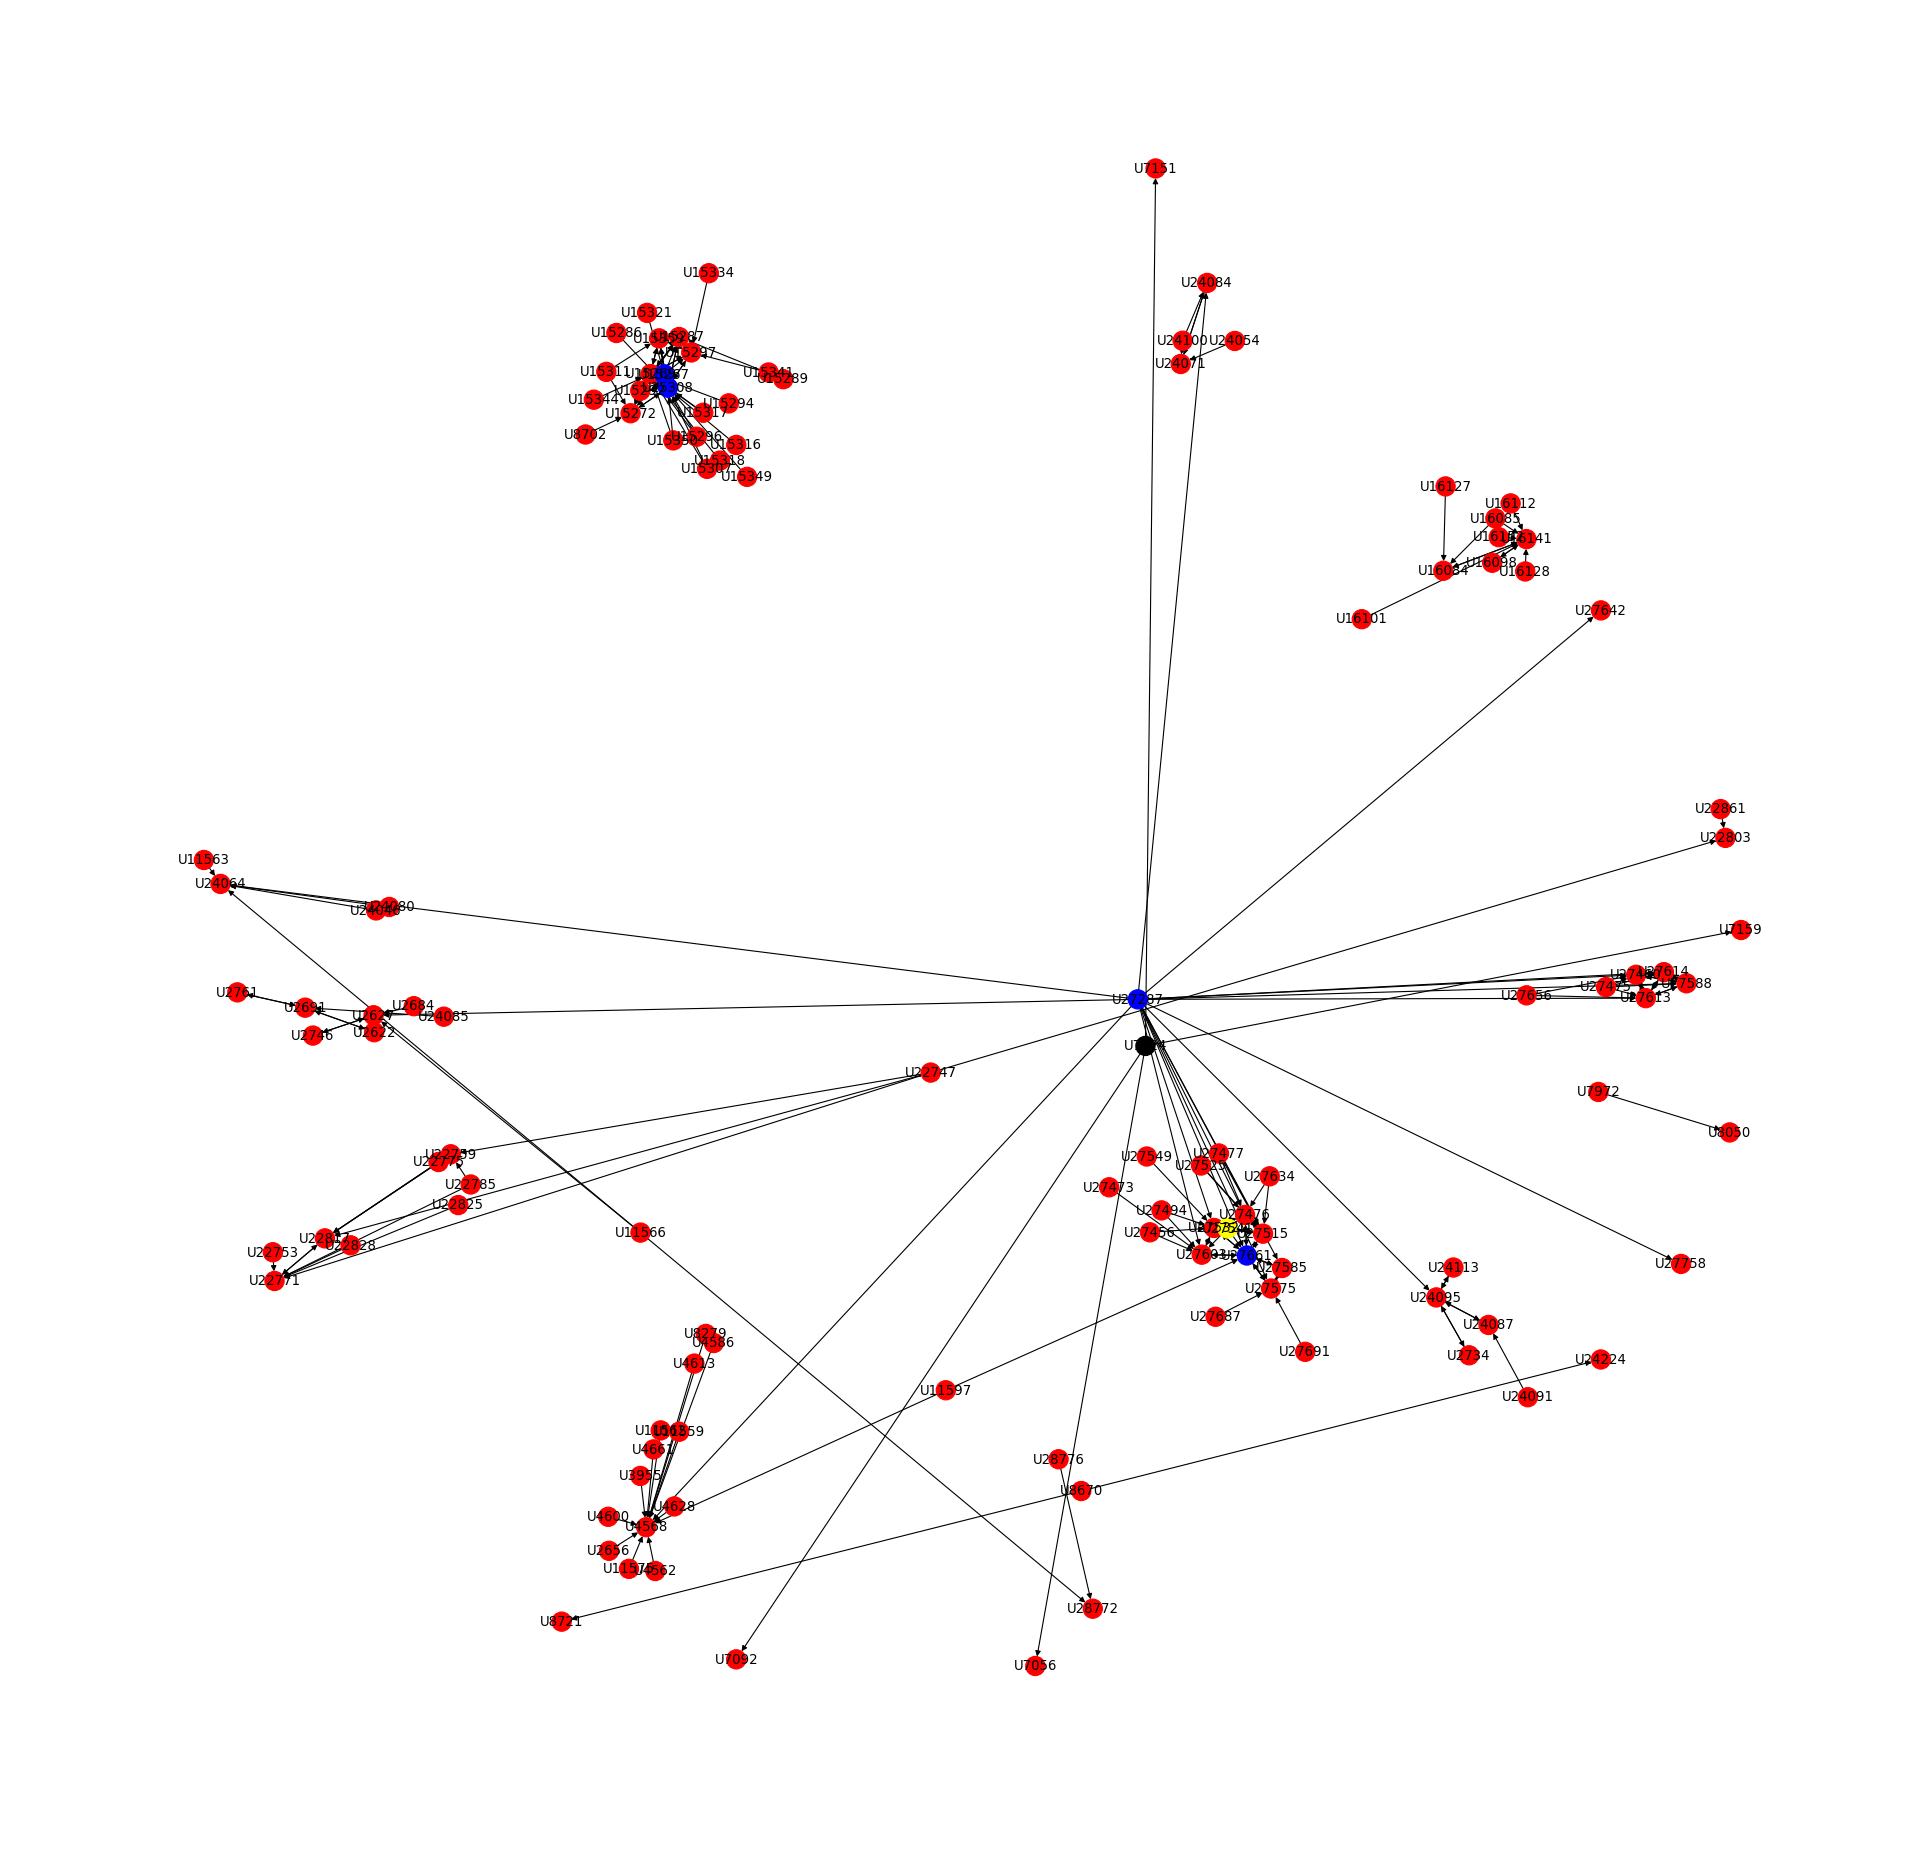

In [27]:
# full-fill the missing value and make a new graph for the Bay Area
from collections import ChainMap

pre1,pre2,pre3 = prediction_degree_class()
prediction_location = ChainMap(pre1,pre2,pre3)
print('high degree class')
proba1 = testLocation(pre1)/100
print('\n\nmid degree class')
proba2 = testLocation(pre2)/100
print('\n\nlow degree class')
proba3 = testLocation(pre3)/100
dic1 = ChainMap(location,prediction_location)

emp_noValues = []
for n in G:
    if n not in prediction_location or n not in location:
        emp_noValues.append(n)


# prediction_location_for_novalues = naive_method(dic1,G,emp_noValues)
# prediction_all = ChainMap(prediction_location,prediction_location_for_novalues)

prediction_all = ChainMap(prediction_location) 

loc_matched,loc_key_matched = strMatch('bay',location)
loc_matched_pred1,loc_key_matched_pred1 = strMatch('bay',pre1)
loc_matched_pred2,loc_key_matched_pred2 = strMatch('bay',pre2)
loc_matched_pred2,loc_key_matched_pred3 = strMatch('bay',pre3)
loc_key_matched_pred = loc_key_matched_pred1 + loc_key_matched_pred2 + loc_key_matched_pred3
loc_key_all = loc_key_matched + loc_key_matched_pred
edges = []
G_Bay = nx.DiGraph()

influence_matrix = {}

for i in G:
    influence_matrix[i] = 0
for k in G:
    for ngb in G[k]:
        if ngb in loc_key_matched and ngb not in loc_key_matched_pred:
            edges.append((k,ngb,{'weight':1}))
            influence_matrix[k] += 1
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred1:    
            edges.append((k,ngb,{'weight':proba1}))
            influence_matrix[k] += proba1
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred2:
            edges.append((k,ngb,{'weight':proba2}))
            influence_matrix[k] += proba2
        elif ngb not in loc_key_matched and ngb in loc_key_matched_pred3:
            edges.append((k,ngb,{'weight':proba3}))
            influence_matrix[k] += proba3
G_Bay.add_edges_from(edges)

influence_list = [(j,i) for i,j in influence_matrix.items()]
influence_list = sorted(influence_list, reverse = True)

pr = {}
pr1 = {}
for i in G_Bay:
    pr[i] = G_Bay.out_degree(i)

pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

vals = {}
keys = []
a = 5
for i in range(0,a):
    vals[pr_list[i][1]] = float(pr_list[i][0])
    keys.append(pr_list[i][1])
    G_Bay.node[pr_list[i][1]]['color'] = 'yellow'
print('\n\npagerank top 5')
print(keys)
for i in range(a,len(G_Bay)):
    vals[pr_list[i][1]] = float(pr_list[i][0])
    keys.append(pr_list[i][1])
    G_Bay.node[pr_list[i][1]]['color'] = 'red'
    
for i in range(a):
    if influence_list[i][1] in G_Bay.nodes() and G_Bay.node[influence_list[i][1]]['color'] == 'yellow':
        G_Bay.node[influence_list[i][1]]['color'] = 'blue'
    elif influence_list[i][1] in G_Bay.nodes() and G_Bay.node[influence_list[i][1]]['color'] != 'yellow':
        G_Bay.node[influence_list[i][1]]['color'] = 'black'
    elif influence_list[i][1] not in G_Bay.nodes():
        print(influence_list[i])
print('influence top 5')
print(influence_list[:10])

drawGraph(G_Bay)

[(22, 'U27287'), (21, 'U7024'), (7, 'U11566'), (5, 'U3955'), (5, 'U27475')]
[(12.083333333333332, 'U27287'), (4, 'U7024'), (3.358333333333333, 'U15267'), (3.0416666666666665, 'U27661'), (2.7916666666666665, 'U15308'), (2.7916666666666665, 'U15269'), (2.6354626708727653, 'U22747'), (2.6333333333333333, 'U27541'), (2.408333333333333, 'U11566'), (2.225, 'U27532')]
22
21
1
1
2
2
3
1
7
1
drawing the Graph, be patient please ^-^


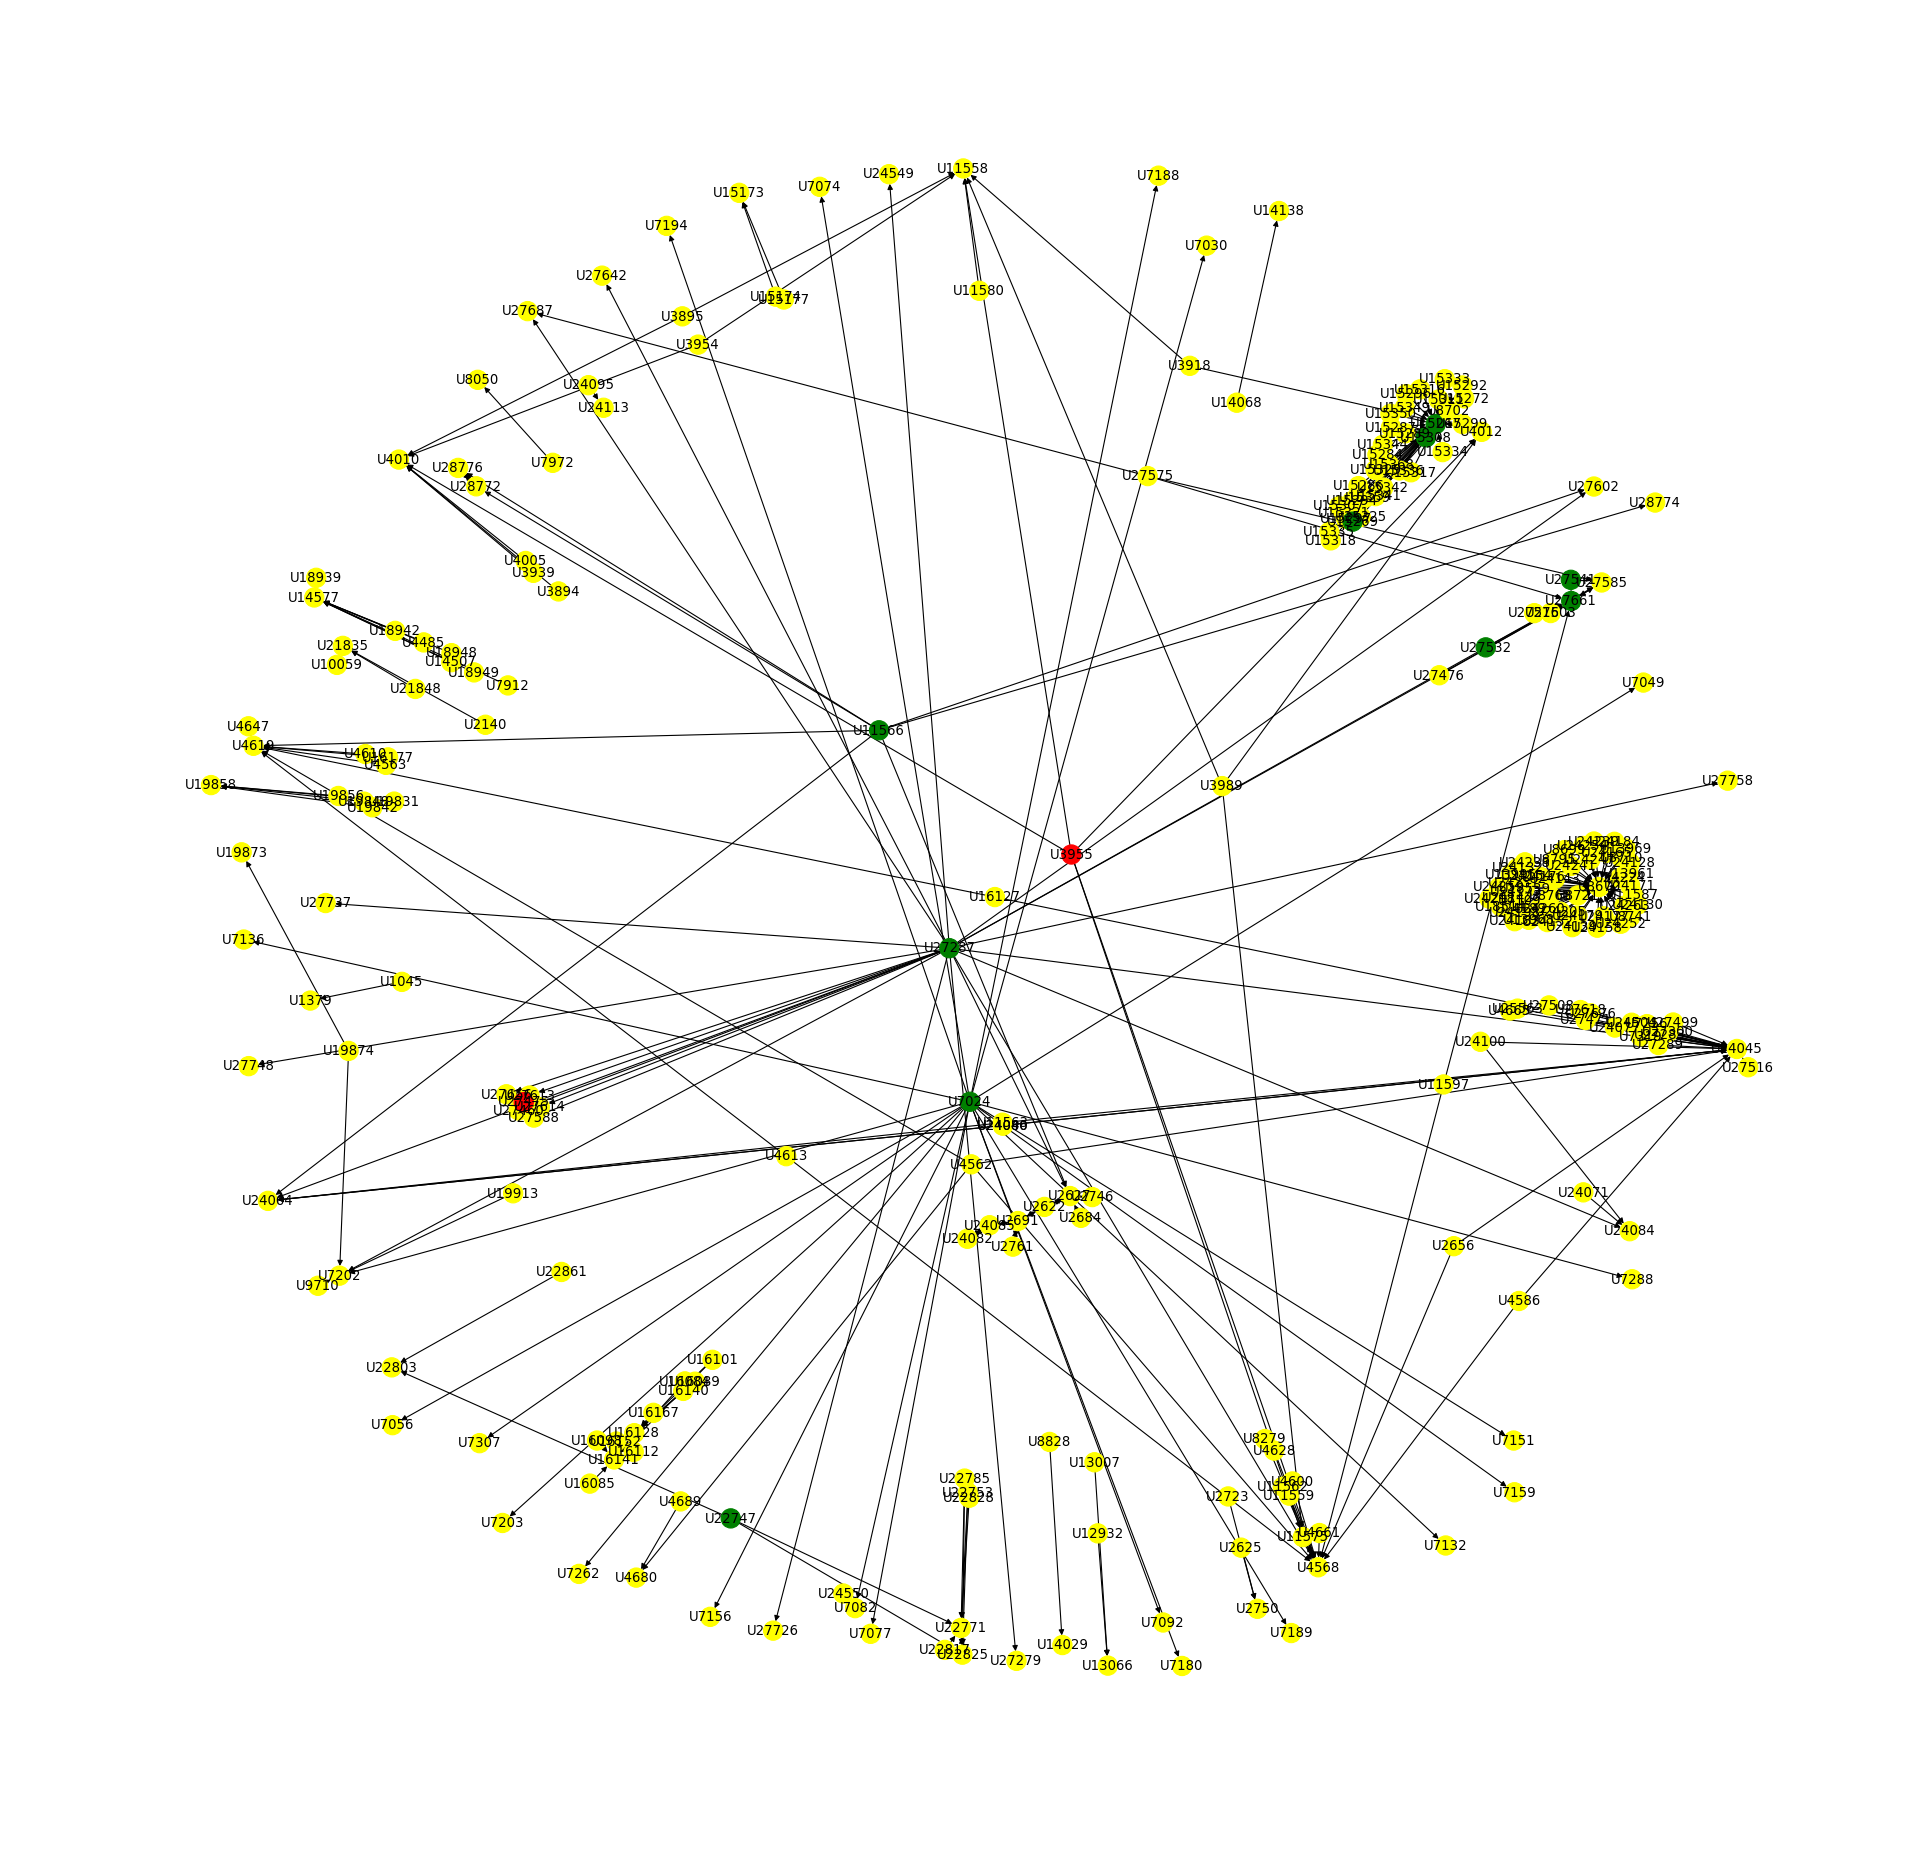

In [31]:
# Test with the real data 
with open('mediumlocation.pickle', 'rb') as handle:
    groundtruth_location = pickle.load(handle)
real_loc_matched,real_loc_key_matched = strMatch('bay',groundtruth_location)
edges = []
G_Bay_real = nx.DiGraph()

for k in G:
    for ngb in G[k]:
        if ngb in real_loc_key_matched:
            edges.append((k,ngb,{'weight':1}))
G_Bay_real.add_edges_from(edges)
pr = {}
for i in G_Bay_real:
    pr[i] = G_Bay_real.out_degree(i)
pr_list = [(n_val,n_key) for n_key,n_val in pr.items()]
pr_list = sorted(pr_list,reverse= True)

real_vals = {}
real_keys = []
alpha = 5
for i in range(0,alpha):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real.node[pr_list[i][1]]['color'] = 'red'
print(pr_list[:5])
for i in range(alpha,len(G_Bay_real)):
    real_vals[pr_list[i][1]] = float(pr_list[i][0])
    real_keys.append(pr_list[i][1])
    G_Bay_real.node[pr_list[i][1]]['color'] = 'yellow'

l2 = influence_list[:10]   
print(l2)
for i in l2:
    print(pr[i[1]])
for i in l2:
    i = i[1]
    if i in real_keys and i in G_Bay_real:
        G_Bay_real.node[i]['color'] = 'green'
    else:
        G_Bay_real.node[i]['color'] = 'blue'
    
drawGraph(G_Bay_real)


In [ ]:
### Data mining location:
# define that who lives in BAY Area , the location number is 1 who not is distributed by 0:

loc_st = {}
loc_normalized = {}
for i in location:
    if location[i]!=[]:
        loc_normalized[i] = 0
    for loc in location[i]:
        if loc.find('bay')>0:
            loc_normalized[i]=1
        if loc not in loc_st:
            loc_st[loc] = [i]
        if loc in loc_st:
            loc_st[loc].append(i)
len(loc_normalized)       


In [ ]:
for i in loc_st:
    if i.find('bay')>0:
        print(i + '  has      %d   people' % len(loc_st[i]))


In [ ]:
# Bay livers' employement and college
no_col = []
no_emp = []
col_st = {}
col_normalized = {}
emp_st = {}
emp_normalized = {}
for i in loc_st:
    if i.find('bay')>0:
        print(i + '  has      %d   people' % len(loc_st[i]))
        for k in loc_st[i]:
            if k in employer:
                for e in employer[k]:
                    if e not in emp_st:
                        emp_st[e] = [k]
                    else:
                        emp_st[e].append(k)
                print(employer[k])
            else: no_emp.append(k)   
            if k in college:
                for e in college[k]:
                    if e not in col_st:
                        col_st[e] = [k]
                    else:
                        col_st[e].append(k)
                print(college[k])
            else: no_col.append(k)
no_col_emp = [v for v in no_col if v in no_emp]
no_col_emp

In [ ]:
col_st

In [ ]:
for i in G:
    G.nodes[i]['color'] = 'y'
a,b = strMatch('bay',location)
for i in b:
    G.nodes[i]['color'] = 'r'
    
drawGraph(G.subgraph(b))

In [ ]:

def find_wrong_prediction(pre,pre2):
    for i in pre:
        if pre[i]!=groundtruth_location[i]:
            print(i,pre[i],pre2[i])
            print('real: ',groundtruth_location[i])
            for k in G[i]:
                if k in groundtruth_location:
                    print(i,'neighbors ',k,' lives',groundtruth_location[k])
                    


pre = prediction_by_community(location,empty_nodes,G1)
emp = [v for v in pre]
pre2 = naive_method(location,G1,empty_nodes)
find_wrong_prediction(pre,pre2)
testLocation(pre)


In [ ]:
len(pre)

In [ ]:
nd = []
for i in empty_nodes:
    if i not in pre:
        nd.append(i)
pre3 = naive_method(location,G,nd)
testLocation(pre3)

In [ ]:
for i in G:
    G.nodes[i]['color'] = 'y'
a,b = strMatch('bay',l)
for i in b:
    G.nodes[i]['color'] = 'r'
testLocation({v:['san francisco bay area'] for v in b})
drawGraph(G.subgraph(b))

In [ ]:
testCollege(prediction_by_community(college,empty_nodes,G1,rst_com))
testEmployer(prediction_by_community(employer,empty_nodes,G1,rst_com))
testLocation(prediction_by_community(location,empty_nodes,G1,rst_com))

In [ ]:
l_pre = []
m_pre = []
h_pre = []
for node in pre:
    if node in node_high_dgr:
        h_pre.append(node)
    elif node in node_mid_dgr:
        m_pre.append(node)
    elif node in node_low_dgr:
        l_pre.append(node)


In [ ]:
print(len(l_pre),'  ',len(node_low_dgr))
print(len(m_pre),'  ',len(node_mid_dgr))
print(len(h_pre),'  ',len(node_high_dgr))


In [ ]:
# low degree node neighbors are 
i = 0
j = 0
k = 0
visited = []
for node in node_low_dgr:
    
    for n in G[node]:
        if n in node_low_dgr :
            i += 1
        elif n in node_mid_dgr :
            j += 1
        elif n in node_high_dgr:
            k += 1 
        visited.append(n)
print(i,j,k)

In [ ]:
i = 0
j = 0
k = 0
visited = []
for node in node_mid_dgr:
    
    for n in G[node]:
        if n in node_low_dgr:
            i += 1
        elif n in node_mid_dgr:
            j += 1
        elif n in node_high_dgr:
            k += 1 
        visited.append(n)
print(i,j,k)

In [ ]:
i = 0
j = 0
k = 0
visited = []
for node in node_high_dgr:
    
    for n in G[node]:
        if n in node_low_dgr :
            i += 1
        elif n in node_mid_dgr:
            j += 1
        elif n in node_high_dgr :
            k += 1 
        visited.append(n)
print(i,j,k)

In [ ]:
import sys
import time

  
for k in range(3,7):
        print ("############# k值: %d ################" % k)
        start_time = time.clock()
        rst_com = find_community(G,k)
        end_time = time.clock()
        print ("计算耗时(秒)：%.3f" % (end_time-start_time))
        print ("生成的社区数：%d" % len(rst_com))
        print(rst_com)

In [ ]:
loc_st={}
for i in groundtruth_location:
    for j in groundtruth_location[i]:
        if j not in loc_st:
            loc_st[j] = [i]
        else:
            loc_st[j].append(i)
loc_st = sorted(loc_st.items(),key = lambda t:len(t[1]),reverse=True)
for i in range(10):
    print(loc_st[i][0],len(loc_st[i][1]))

In [ ]:
import pandas as pd

index = 0
for i in G:
    index += len(G[i])
idx = [v for v in range(index)]

df_all = pd.DataFrame(index=idx,columns = ['id','location','college','employer','ngb_id','ngb_location','ngb_college','ngb_employer'])

In [ ]:
index = 0
for i in G:
    for j in G[i]:
        df_all['id'][index] = i 
        df_all['ngb_id'][index] = j
        if i in location and location[i]!=[]:
            df_all['location'][index] = loc_normalized[i]
        if i in college and college[i] != []:
            df_all['college'][index] = college[i][0]
        if i in employer and employer[i]!=[]:
            df_all['employer'][index] = employer[i][0]
        if j in location and location[j]!=[]:
            df_all['ngb_location'][index] = loc_normalized[j]
        if j in college and college[j] != []:
            df_all['ngb_college'][index] = college[j][0]
        if j in employer and employer[j]!=[]:
            df_all['ngb_employer'][index] = employer[j][0]
    
        index += 1
            
df_all

In [ ]:
df_all[df_all.id.notna()]